In [1]:
import pandas as pd
import numpy as np
import json
import gzip
import os
import os.path
from os import listdir
import multiprocessing
from tqdm import tqdm
import mmap
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
import py_entitymatching as em
import py_stringmatching as sm
import scipy
from scipy.io import arff
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
#read table to dataframe and create train/test split with equal distribution of labels within table
all_tables = pd.read_csv('../../src/data/data/CSV_files/relevant_tables_more_than_20.csv')
all_tables = all_tables.drop(columns={'Unnamed: 0'})
#pd.set_option('display.max_columns', None)
all_tables

filename      Class  num_rows  \
0                  Book_12min.com_September2020.json.gz       Book     366.0   
1                Book_19shuwu.com_September2020.json.gz       Book     250.0   
2      Book_1carpetcleaning.co.uk_September2020.json.gz       Book    1004.0   
3           Book_2014brazil.co.uk_September2020.json.gz       Book     387.0   
4              Book_24symbols.com_September2020.json.gz       Book    5171.0   
...                                                 ...        ...       ...   
54185   TVEpisode_yara-online.org_September2020.json.gz  TVEpisode      40.0   
54186    TVEpisode_yesmoviess.com_September2020.json.gz  TVEpisode      37.0   
54187     TVEpisode_zazangels.com_September2020.json.gz  TVEpisode      38.0   
54188     TVEpisode_zebrahead.org_September2020.json.gz  TVEpisode      80.0   
54189     TVEpisode_zoids-col.net_September2020.json.gz  TVEpisode      28.0   

       num_columns  num_columns_selected  num_NAs  percentage_col_NA  \
0              9.0                   5.0      166           0.286885   
1              8.0                   5.0        0           0.000000   
2             12.0                   9.0        0           0.000000   
3             11.0                   9.0        0           0.000000   
4              8.0                   5.0       17           0.001740   
...            ...                   ...      ...                ...   
54185          9.0                   2.0        0           0.000000   
54186          9.0                   2.0        0           0.000000   
54187          8.0                   2.0        0           0.000000   
54188          7.0                   2.0        0           0.000000   
54189          8.0                   2.0        0           0.000000   

       percentage_table_NA  sum_NA_sel_col  Book_aggregaterating  ...  \
0                 0.090710           830.0                     1  ...   
1                 0.000000             0.0                     0  ...   
2                 0.000000             0.0                     1  ...   
3                 0.000000             0.0                     1  ...   
4                 0.000658            85.0                     0  ...   
...                    ...             ...                   ...  ...   
54185             0.000000             0.0                     0  ...   
54186             0.000000             0.0                     0  ...   
54187             0.000000             0.0                     0  ...   
54188             0.000000             0.0                     0  ...   
54189             0.000000             0.0                     0  ...   

       Restaurant_menu  Restaurant_name  Restaurant_openinghours  \
0                    0                0                        0   
1                    0                0                        0   
2                    0                0                        0   
3                    0                0                        0   
4                    0                0                        0   
...                ...              ...                      ...   
54185                0                0                        0   
54186                0                0                        0   
54187                0                0                        0   
54188                0                0                        0   
54189                0                0                        0   

       Restaurant_openinghoursspecification  Restaurant_pricerange  \
0                                         0                      0   
1                                         0                      0   
2                                         0                      0   
3                                         0                      0   
4                                         0                      0   
...                                     ...                    ...   
54185                                

In [3]:
all_tables.loc[all_tables['num_rows'] <= 40, 'Small'] = 1 
all_tables.loc[(all_tables['num_rows'] > 40) & (all_tables['num_rows'] <= 160), 'Medium'] = 1
all_tables.loc[all_tables['num_rows'] > 160, 'Large'] = 1 
all_tables = all_tables.fillna(0)
all_tables

filename      Class  num_rows  \
0                  Book_12min.com_September2020.json.gz       Book     366.0   
1                Book_19shuwu.com_September2020.json.gz       Book     250.0   
2      Book_1carpetcleaning.co.uk_September2020.json.gz       Book    1004.0   
3           Book_2014brazil.co.uk_September2020.json.gz       Book     387.0   
4              Book_24symbols.com_September2020.json.gz       Book    5171.0   
...                                                 ...        ...       ...   
54185   TVEpisode_yara-online.org_September2020.json.gz  TVEpisode      40.0   
54186    TVEpisode_yesmoviess.com_September2020.json.gz  TVEpisode      37.0   
54187     TVEpisode_zazangels.com_September2020.json.gz  TVEpisode      38.0   
54188     TVEpisode_zebrahead.org_September2020.json.gz  TVEpisode      80.0   
54189     TVEpisode_zoids-col.net_September2020.json.gz  TVEpisode      28.0   

       num_columns  num_columns_selected  num_NAs  percentage_col_NA  \
0              9.0                   5.0      166           0.286885   
1              8.0                   5.0        0           0.000000   
2             12.0                   9.0        0           0.000000   
3             11.0                   9.0        0           0.000000   
4              8.0                   5.0       17           0.001740   
...            ...                   ...      ...                ...   
54185          9.0                   2.0        0           0.000000   
54186          9.0                   2.0        0           0.000000   
54187          8.0                   2.0        0           0.000000   
54188          7.0                   2.0        0           0.000000   
54189          8.0                   2.0        0           0.000000   

       percentage_table_NA  sum_NA_sel_col  Book_aggregaterating  ...  \
0                 0.090710           830.0                     1  ...   
1                 0.000000             0.0                     0  ...   
2                 0.000000             0.0                     1  ...   
3                 0.000000             0.0                     1  ...   
4                 0.000658            85.0                     0  ...   
...                    ...             ...                   ...  ...   
54185             0.000000             0.0                     0  ...   
54186             0.000000             0.0                     0  ...   
54187             0.000000             0.0                     0  ...   
54188             0.000000             0.0                     0  ...   
54189             0.000000             0.0                     0  ...   

       Restaurant_openinghoursspecification  Restaurant_pricerange  \
0                                         0                      0   
1                                         0                      0   
2                                         0                      0   
3                                         0                      0   
4                                         0                      0   
...                                     ...                    ...   
54185                                     0                      0   
54186                                     0                      0   
54187                                     0                      0   
54188                                     0                      0   
54189                                     0                      0   

       Restaurant_servescuisine  Restaurant_telephone  \
0                             0                     0   
1                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   
...                         ...                   ...   
54185                         0                     0   
54186                         0                

In [18]:
 liste  = list(all_tables.iloc[:,1:2])
 liste2 = list(all_tables.iloc[:,9:])
 liste = liste + liste2
 liste

['Class',
 'Book_aggregaterating',
 'Book_author',
 'Book_bookedition',
 'Book_bookformat',
 'Book_datepublished',
 'Book_genre',
 'Book_inlanguage',
 'Book_isbn',
 'Book_name',
 'Book_numberofpages',
 'Book_offers',
 'Book_publisher',
 'CreativeWork_aggregaterating',
 'CreativeWork_alternativeheadline',
 'CreativeWork_articlebody',
 'CreativeWork_author',
 'CreativeWork_commentcount',
 'CreativeWork_copyrightholder',
 'CreativeWork_copyrightyear',
 'CreativeWork_creator',
 'CreativeWork_datecreated',
 'CreativeWork_datemodified',
 'CreativeWork_datepublished',
 'CreativeWork_genre',
 'CreativeWork_headline',
 'CreativeWork_inlanguage',
 'CreativeWork_interactioncount',
 'CreativeWork_interactionstatistic',
 'CreativeWork_interactiontype',
 'CreativeWork_keywords',
 'CreativeWork_mainentityofpage',
 'CreativeWork_name',
 'CreativeWork_offers',
 'CreativeWork_publisher',
 'CreativeWork_version',
 'Event_doortime',
 'Event_duration',
 'Event_enddate',
 'Event_eventattendancemode',
 'Even

In [5]:
all_tables = all_tables.fillna(0)

In [19]:
path = '/work-ceph/bizer-tp2021/data_integration_using_deep_learning/src/data/data/CSV_files'
tables = pd.read_csv(path + '/all_files_cleaned.csv')
tables = tables.drop(columns={'Unnamed: 0'})
columns_sorted = tables.groupby('filename')['column_name'].apply(list).reset_index(name='listofcolumns')
columns_sorted.filename = columns_sorted.filename.str.split('_', expand = True)
columns_sorted.index = columns_sorted['filename']
columns_sorted

filename  \
filename                         
Book                      Book   
CreativeWork      CreativeWork   
Event                    Event   
Hotel                    Hotel   
LocalBusiness    LocalBusiness   
MusicAlbum          MusicAlbum   
MusicRecording  MusicRecording   
Person                  Person   
Place                    Place   
Product                Product   
Recipe                  Recipe   
Restaurant          Restaurant   
TVEpisode            TVEpisode   

                                                                                                      listofcolumns  
filename                                                                                                             
Book            [name, author, isbn, publisher, offers, datepublished, numberofpages, bookformat, inlanguage, ge...  
CreativeWork    [headline, author, datepublished, datemodified, name, publisher, mainentityofpage, interactionst...  
Event           [name, enddate, location, performer, organizer, eventstatus, eventattendancemode, duration, door...  
Hotel                               [name, address, telephone, pricerange, geo, aggregaterating, starrating, email]  
LocalBusiness   [name, address, telephone, geo, pricerange, aggregaterating, email, sameas, faxnumber, openingho...  
MusicAlbum                                                                       [name, byartist, track, numtracks]  
MusicRecording                               [name, duration, byartist, inalbum, datepublished, genre, datecreated]  
Person          [mainentityofpage, jobtitle, birthdate, givenname, familyname, telephone, email, deathdate, addi...  
Place                                                     [name, geo, telephone, sameas, openinghoursspecification]  
Product         [name, offers, brand, aggregaterating, mpn, category, review, manufacturer, itemcondition, model...  
Recipe          [name, recipeinstructions, author, recipeyield, recipeingredient, preptime, cooktime, datepublis...  
Restaurant      [name, address, telephone, servescuisine, geo, pricerange, aggregaterating, hasmenu, acceptsrese...  
TVEpisode                                                                       [name, partofseries, episodenumber]

In [7]:
#Split all Tables in large train and test set
#def traintestsplit():
#for index in columns_sorted.filename:
#    index_df = pd.DataFrame()
#    liste = []
#    index_df = small[small['Class']==index]
    #display(index_df)
#    liste  = list([col for col in small if col.startswith(index+'_')])
#liste = list([col for col in small if col.startswith(index+'_')])
X = np.array(all_tables['filename'])
y = np.array(all_tables[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.18, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/'+index+'/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Large/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        if file in train_set:
            #for file in train_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Test/'+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir+'Test/') if file.endswith('.json.gz')]))

TRAIN: [    0     1     3 ... 54187 54188 54189] TEST: [    2    15    18 ... 54177 54184 54186]
TRAIN: [    0     2     3 ... 54184 54187 54189] TEST: [    1     6    13 ... 54185 54186 54188]
TRAIN: [    0     2     3 ... 54186 54187 54189] TEST: [    1     7     9 ... 54176 54182 54188]
{'Person_advantaira.com_September2020.json.gz', 'Recipe_veggietracker.com_September2020.json.gz', 'MusicRecording_brittawolfert.com_September2020.json.gz', 'Person_bramille.com_September2020.json.gz', 'Person_cliffordchance.com_September2020.json.gz', 'Product_paperose.com.my_September2020.json.gz', 'Person_foundsfuneralhome.com_September2020.json.gz', 'Product_honeyhairco.com_September2020.json.gz', 'Product_getbeast.com_September2020.json.gz', 'Hotel_hotel-rv.com_September2020.json.gz', 'Product_farahasmar.com_September2020.json.gz', 'Product_incrediwearcanada.com_September2020.json.gz', 'Event_wellnessloungesd.com_September2020.json.gz', 'CreativeWork_ankiros.com_September2020.json.gz', 'LocalBusi

In [7]:
listeTe = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Large/Test/')
listeTr = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Large/Train/')

In [8]:
#len(listeTe)
len(listeTr)

44435

In [9]:
large_train = all_tables[all_tables['filename'].isin(listeTr)]
large_train.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Large/Training_Files.csv')
large_train


filename      Class  num_rows  \
0                  Book_12min.com_September2020.json.gz       Book     366.0   
2      Book_1carpetcleaning.co.uk_September2020.json.gz       Book    1004.0   
3           Book_2014brazil.co.uk_September2020.json.gz       Book     387.0   
4              Book_24symbols.com_September2020.json.gz       Book    5171.0   
5              Book_2d-market.com_September2020.json.gz       Book     262.0   
...                                                 ...        ...       ...   
54184    TVEpisode_yahooboard.net_September2020.json.gz  TVEpisode      55.0   
54185   TVEpisode_yara-online.org_September2020.json.gz  TVEpisode      40.0   
54186    TVEpisode_yesmoviess.com_September2020.json.gz  TVEpisode      37.0   
54187     TVEpisode_zazangels.com_September2020.json.gz  TVEpisode      38.0   
54189     TVEpisode_zoids-col.net_September2020.json.gz  TVEpisode      28.0   

       num_columns  num_columns_selected  num_NAs  percentage_col_NA  \
0              9.0                   5.0      166           0.286885   
2             12.0                   9.0        0           0.000000   
3             11.0                   9.0        0           0.000000   
4              8.0                   5.0       17           0.001740   
5             19.0                   7.0       76           0.129771   
...            ...                   ...      ...                ...   
54184          9.0                   2.0        0           0.000000   
54185          9.0                   2.0        0           0.000000   
54186          9.0                   2.0        0           0.000000   
54187          8.0                   2.0        0           0.000000   
54189          8.0                   2.0        0           0.000000   

       percentage_table_NA  sum_NA_sel_col  Book_aggregaterating  ...  \
0                 0.090710           830.0                     1  ...   
2                 0.000000             0.0                     1  ...   
3                 0.000000             0.0                     1  ...   
4                 0.000658            85.0                     0  ...   
5                 0.041439           532.0                     0  ...   
...                    ...             ...                   ...  ...   
54184             0.000000             0.0                     0  ...   
54185             0.000000             0.0                     0  ...   
54186             0.000000             0.0                     0  ...   
54187             0.000000             0.0                     0  ...   
54189             0.000000             0.0                     0  ...   

       Restaurant_openinghoursspecification  Restaurant_pricerange  \
0                                         0                      0   
2                                         0                      0   
3                                         0                      0   
4                                         0                      0   
5                                         0                      0   
...                                     ...                    ...   
54184                                     0                      0   
54185                                     0                      0   
54186                                     0                      0   
54187                                     0                      0   
54189                                     0                      0   

       Restaurant_servescuisine  Restaurant_telephone  \
0                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   
5                             0                     0   
...                         ...                   ...   
54184                         0                     0   
54185                         0                

In [8]:
large_test = all_tables[all_tables['filename'].isin(listeTe)]
large_test.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Large/Test_Files.csv')
large_test

filename      Class  \
1                    Book_19shuwu.com_September2020.json.gz       Book   
7                Book_4thestate.co.uk_September2020.json.gz       Book   
9                   Book_80mundos.com_September2020.json.gz       Book   
21           Book_alexanderstreet.com_September2020.json.gz       Book   
28                    Book_apress.com_September2020.json.gz       Book   
...                                                     ...        ...   
54165         TVEpisode_univision.com_September2020.json.gz  TVEpisode   
54174          TVEpisode_votenova.org_September2020.json.gz  TVEpisode   
54176  TVEpisode_watermarkthefilm.com_September2020.json.gz  TVEpisode   
54182              TVEpisode_ww2d.org_September2020.json.gz  TVEpisode   
54188         TVEpisode_zebrahead.org_September2020.json.gz  TVEpisode   

       num_rows  num_columns  num_columns_selected  num_NAs  \
1         250.0          8.0                   5.0        0   
7        1336.0         10.0                   6.0      523   
9        2748.0         10.0                   7.0      696   
21        197.0         11.0                   5.0      146   
28        399.0          8.0                   5.0      124   
...         ...          ...                   ...      ...   
54165    3150.0          5.0                   2.0        0   
54174      55.0          9.0                   2.0        0   
54176      40.0          9.0                   2.0        0   
54182      54.0          8.0                   2.0        0   
54188      80.0          7.0                   2.0        0   

       percentage_col_NA  percentage_table_NA  sum_NA_sel_col  \
1               0.000000             0.000000             0.0   
7               0.391467             0.065245          3138.0   
9               0.129185             0.036182          4872.0   
21              0.446701             0.148223           730.0   
28              0.308271             0.062155           620.0   
...                  ...                  ...             ...   
54165           0.000000             0.000000             0.0   
54174           0.000000             0.000000             0.0   
54176           0.000000             0.000000             0.0   
54182           0.000000             0.000000             0.0   
54188           0.000000             0.000000             0.0   

       Book_aggregaterating  ...  Restaurant_openinghoursspecification  \
1                         0  ...                                     0   
7                         0  ...                                     0   
9                         0  ...                                     0   
21                        0  ...                                     0   
28                        0  ...                                     0   
...                     ...  ...                                   ...   
54165                     0  ...                                     0   
54174                     0  ...                                     0   
54176                     0  ...                                     0   
54182                     0  ...                                     0   
54188                     0  ...                                     0   

       Restaurant_pricerange  Restaurant_servescuisine  Restaurant_telephone  \
1                          0                         0                     0   
7                          0                         0                     0   
9                          0                         0                     0   
21                         0                         0                     0   
28                         0                         0                     0   
...                      ...                       ...                   ...   
54165                      0                         0                     0   
54174                      0                         0                     0   
54176          

In [25]:
#Split large test set into medium test set
#def traintestsplit():

X = np.array(large_test['filename'])
y = np.array(large_test[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/TrainTestTables/Large/Test/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Medium/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        #if file in train_set:
            #for file in train_set:
            #print(file)
        #    df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
        #    df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        #print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Test/'+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir+'Test/') if file.endswith('.json.gz')]))

In [7]:
medium_listeTe = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Medium/Test/')
medium_listeTe

['Event_davidlohmueller.com_September2020.json.gz',
 'Product_angelmania.net_September2020.json.gz',
 'Product_jd-sports.com.au_September2020.json.gz',
 'Recipe_ozlemsturkishtable.com_September2020.json.gz',
 'Product_fantastichumanhair.com_September2020.json.gz',
 'Recipe_mexicanplease.com_September2020.json.gz',
 'Product_swimsale.com_September2020.json.gz',
 'MusicRecording_shanescheib.com_September2020.json.gz',
 'Product_gusti-leather.co.uk_September2020.json.gz',
 'Restaurant_latelier28.com_September2020.json.gz',
 'Product_ladybaileycaravans.co.uk_September2020.json.gz',
 'Product_ekkip.com_September2020.json.gz',
 'Event_rootszerowastemarket.com_September2020.json.gz',
 'Product_edwards-jewelers.com_September2020.json.gz',
 'Event_pcflv.org_September2020.json.gz',
 'MusicAlbum_lizasongs.com_September2020.json.gz',
 'MusicRecording_sarahgosleereed.com_September2020.json.gz',
 'Recipe_momeatspaleo.com_September2020.json.gz',
 'Product_bokarocake.com_September2020.json.gz',
 'Prod

In [8]:
medium_test = all_tables[all_tables['filename'].isin(medium_listeTe)]
medium_test.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Medium/MTest_Files.csv')
medium_test

filename      Class  num_rows  \
38          Book_atlaskitap.com_September2020.json.gz       Book    2015.0   
41          Book_auth-e83.co.uk_September2020.json.gz       Book     947.0   
61       Book_berghahnbooks.com_September2020.json.gz       Book     697.0   
79       Book_boldtypebooks.com_September2020.json.gz       Book     105.0   
106             Book_calamo.com_September2020.json.gz       Book   15746.0   
...                                               ...        ...       ...   
54036      TVEpisode_ezfilm.net_September2020.json.gz  TVEpisode     101.0   
54055     TVEpisode_grnrngr.com_September2020.json.gz  TVEpisode     910.0   
54118     TVEpisode_semhade.com_September2020.json.gz  TVEpisode      89.0   
54123      TVEpisode_sinefy.net_September2020.json.gz  TVEpisode      71.0   
54143  TVEpisode_thefmovies.com_September2020.json.gz  TVEpisode     254.0   

       num_columns  num_columns_selected  num_NAs  percentage_col_NA  \
38             8.0                   5.0        1           0.000496   
41            12.0                   9.0        0           0.000000   
61            12.0                   9.0        6           0.002869   
79            12.0                   7.0        7           0.057143   
106           10.0                   7.0     6174           0.193891   
...            ...                   ...      ...                ...   
54036          5.0                   2.0        0           0.000000   
54055          7.0                   3.0        0           0.000000   
54118          5.0                   2.0        0           0.000000   
54123          5.0                   2.0       13           0.183099   
54143          9.0                   2.0        0           0.000000   

       percentage_table_NA  sum_NA_sel_col  Book_aggregaterating  ...  \
38                0.000099             5.0                     0  ...   
41                0.000000             0.0                     1  ...   
61                0.000956            54.0                     0  ...   
79                0.009524            49.0                     0  ...   
106               0.056014         43218.0                     0  ...   
...                    ...             ...                   ...  ...   
54036             0.000000             0.0                     0  ...   
54055             0.000000             0.0                     0  ...   
54118             0.000000             0.0                     0  ...   
54123             0.091549            26.0                     0  ...   
54143             0.000000             0.0                     0  ...   

       Restaurant_openinghoursspecification  Restaurant_pricerange  \
38                                        0                      0   
41                                        0                      0   
61                                        0                      0   
79                                        0                      0   
106                                       0                      0   
...                                     ...                    ...   
54036                                     0                      0   
54055                                     0                      0   
54118                                     0                      0   
54123                                     0                      0   
54143                                     0                      0   

       Restaurant_servescuisine  Restaurant_telephone  \
38                            0                     0   
41                            0                     0   
61                            0                     0   
79                            0                     0   
106                           0                     0   
...                         ...                   ...   
54036                         0                     0   
54055                         0                     0   
54118       

In [9]:
#Split medium test set into small test set
#def traintestsplit():

X = np.array(medium_test['filename'])
y = np.array(medium_test[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/TrainTestTables/Medium/Test/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Small/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        #if file in train_set:
            #for file in train_set:
            #print(file)
        #    df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
        #    df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        #print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Test/'+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir+'Test/') if file.endswith('.json.gz')]))

TRAIN: [   0    1    2 ... 1956 1957 1958] TEST: [   9   13   16   17   19   26   28   33   35   38   46   51   53   55
   62   64   79   89   91  103  108  114  116  117  122  130  133  134
  143  145  149  150  151  153  154  157  161  165  190  193  200  201
  202  214  215  216  217  223  225  227  229  230  232  238  252  257
  263  276  281  293  295  299  302  315  317  320  328  337  345  347
  349  376  378  384  385  386  389  392  395  399  400  401  403  409
  419  430  431  441  443  449  454  466  468  470  472  473  484  485
  488  492  498  501  508  509  512  517  519  520  528  531  537  539
  540  541  546  556  563  564  565  574  586  616  625  627  635  640
  641  642  646  647  648  653  657  659  673  676  683  687  690  696
  699  703  717  728  735  738  739  740  742  750  751  758  761  763
  766  768  773  775  776  779  791  795  797  800  801  804  805  806
  837  850  852  853  854  871  873  875  877  880  891  895  899  913
  919  920  929  930  934  9

In [4]:
small_listeTe = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Small/Test/')
small_listeTe

['Product_ladybaileycaravans.co.uk_September2020.json.gz',
 'MusicAlbum_lizasongs.com_September2020.json.gz',
 'Place_thetravellingfool.com_September2020.json.gz',
 'Product_sportforyou.net_September2020.json.gz',
 'Person_homeswithlopez.com_September2020.json.gz',
 'Product_keratinbeauty.com_September2020.json.gz',
 'Event_wackenbus.com_September2020.json.gz',
 'Recipe_casalagotastingroom.com_September2020.json.gz',
 'Product_zebraz.com_September2020.json.gz',
 'MusicRecording_alcardillo.com_September2020.json.gz',
 'CreativeWork_fractracker.org_September2020.json.gz',
 'Product_jugais.com_September2020.json.gz',
 'Product_boogemes.com_September2020.json.gz',
 'MusicRecording_zaiaband.com_September2020.json.gz',
 'Product_thatawesomeshirt.com_September2020.json.gz',
 'Restaurant_nashvilledelivers.com_September2020.json.gz',
 'Recipe_completelyketo.com_September2020.json.gz',
 'Person_carepirates.com_September2020.json.gz',
 'MusicRecording_mariachiaguilasdemexico.com_September2020.jso

In [5]:
small_test = all_tables[all_tables['filename'].isin(small_listeTe)]
small_test.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Small/STest_Files.csv')
small_test

filename       Class  \
106                      Book_calamo.com_September2020.json.gz        Book   
201                 Book_follasnovas.com_September2020.json.gz        Book   
472      Book_norfolk-tree-surgeon.co.uk_September2020.json.gz        Book   
510                Book_pirtukakurdi.com_September2020.json.gz        Book   
572            Book_slkbali-lollypop.com_September2020.json.gz        Book   
...                                                        ...         ...   
53789  Restaurant_laterrassedujardin.com_September2020.json.gz  Restaurant   
53835   Restaurant_nashvilledelivers.com_September2020.json.gz  Restaurant   
53935          Restaurant_tahoesbest.com_September2020.json.gz  Restaurant   
54035              TVEpisode_erosnow.com_September2020.json.gz   TVEpisode   
54036               TVEpisode_ezfilm.net_September2020.json.gz   TVEpisode   

       num_rows  num_columns  num_columns_selected  num_NAs  \
106     15746.0         10.0                   7.0     6174   
201      1167.0          7.0                   5.0      181   
472       235.0         11.0                   9.0        0   
510       993.0          8.0                   5.0      218   
572        52.0         13.0                   9.0        7   
...         ...          ...                   ...      ...   
53789      22.0         13.0                   9.0       11   
53835      94.0          9.0                   6.0        2   
53935      32.0         10.0                   7.0        5   
54035      21.0         10.0                   2.0        0   
54036     101.0          5.0                   2.0        0   

       percentage_col_NA  percentage_table_NA  sum_NA_sel_col  \
106             0.193891             0.056014         43218.0   
201             0.152528             0.031020           905.0   
472             0.000000             0.000000             0.0   
510             0.188318             0.043907          1090.0   
572             0.057692             0.014957            63.0   
...                  ...                  ...             ...   
53789           0.363636             0.055556            99.0   
53835           0.021277             0.003546            12.0   
53935           0.093750             0.022321            35.0   
54035           0.000000             0.000000             0.0   
54036           0.000000             0.000000             0.0   

       Book_aggregaterating  ...  Restaurant_openinghoursspecification  \
106                       0  ...                                     0   
201                       0  ...                                     0   
472                       1  ...                                     0   
510                       0  ...                                     0   
572                       0  ...                                     0   
...                     ...  ...                                   ...   
53789                     0  ...                                     1   
53835                     0  ...                                     0   
53935                     0  ...                                     0   
54035                     0  ...                                     0   
54036                     0  ...                                     0   

       Restaurant_pricerange  Restaurant_servescuisine  Restaurant_telephone  \
106                        0                         0                     0   
201                        0                         0                     0   
472                        0                         0                     0   
510                        0                         0                     0   
572                        0                         0                     0   
...                      ...                       ...                   ...   
53789                      1                         1                     1   
53835                      1                      

In [10]:
#Split large train set into medium train set
#def traintestsplit():

X = np.array(large_train['filename'])
y = np.array(large_train[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.22, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/TrainTestTables/Large/Train/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Medium/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        #if file in train_set:
            #for file in train_set:
            #print(file)
        #    df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
        #    df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        #print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir+'Train/') if file.endswith('.json.gz')]))

In [6]:
medium_listeTr = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Medium/Train/')
medium_listeTr

['Product_kingmemorialpark.com_September2020.json.gz',
 'Product_bayerautogroup.com_September2020.json.gz',
 'Product_high-supplies.com_September2020.json.gz',
 'MusicRecording_bencrosbymusic.com_September2020.json.gz',
 'Product_mycraftystencils.com_September2020.json.gz',
 'LocalBusiness_agfg.com.au_September2020.json.gz',
 'LocalBusiness_innatturkeyhill.com_September2020.json.gz',
 'Hotel_khaosanroad.com_September2020.json.gz',
 'Event_ewingnj.org_September2020.json.gz',
 'MusicRecording_robertaumannband.com_September2020.json.gz',
 'Product_stringerfuneral.com_September2020.json.gz',
 'LocalBusiness_zellamsee-kaprun.com_September2020.json.gz',
 'Event_suepellanddesigns.com_September2020.json.gz',
 'Product_onkruidbrander.com_September2020.json.gz',
 'Product_jgmaker3dofficial.com_September2020.json.gz',
 'Event_freewheelinbikes.org_September2020.json.gz',
 'Recipe_kidfriendlythingstodo.com_September2020.json.gz',
 'LocalBusiness_eldercare.com_September2020.json.gz',
 'CreativeWork_

In [7]:
medium_train = all_tables[all_tables['filename'].isin(medium_listeTr)]
medium_train.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Medium/MTrain_Files.csv')
medium_train

filename      Class  \
5                   Book_2d-market.com_September2020.json.gz       Book   
13                 Book_abebooks.co.uk_September2020.json.gz       Book   
14                   Book_abebooks.com_September2020.json.gz       Book   
18               Book_addicusbooks.com_September2020.json.gz       Book   
22     Book_alpiedelaletralibreria.com_September2020.json.gz       Book   
...                                                      ...        ...   
54179               TVEpisode_wliw.org_September2020.json.gz  TVEpisode   
54181          TVEpisode_wussmovie.com_September2020.json.gz  TVEpisode   
54184         TVEpisode_yahooboard.net_September2020.json.gz  TVEpisode   
54186         TVEpisode_yesmoviess.com_September2020.json.gz  TVEpisode   
54187          TVEpisode_zazangels.com_September2020.json.gz  TVEpisode   

       num_rows  num_columns  num_columns_selected  num_NAs  \
5         262.0         19.0                   7.0       76   
13       7349.0         12.0                   8.0     2880   
14       3352.0         12.0                   8.0     2485   
18         89.0         13.0                   7.0       46   
22       1246.0          7.0                   5.0      212   
...         ...          ...                   ...      ...   
54179     961.0         14.0                   2.0      147   
54181      40.0          9.0                   2.0        0   
54184      55.0          9.0                   2.0        0   
54186      37.0          9.0                   2.0        0   
54187      38.0          8.0                   2.0        0   

       percentage_col_NA  percentage_table_NA  sum_NA_sel_col  \
5               0.129771             0.041439           532.0   
13              0.234454             0.048986         23040.0   
14              0.330549             0.092669         19880.0   
18              0.247191             0.073836           322.0   
22              0.115570             0.034029          1060.0   
...                  ...                  ...             ...   
54179           0.152966             0.076483           294.0   
54181           0.000000             0.000000             0.0   
54184           0.000000             0.000000             0.0   
54186           0.000000             0.000000             0.0   
54187           0.000000             0.000000             0.0   

       Book_aggregaterating  ...  Restaurant_openinghoursspecification  \
5                         0  ...                                     0   
13                        1  ...                                     0   
14                        1  ...                                     0   
18                        0  ...                                     0   
22                        0  ...                                     0   
...                     ...  ...                                   ...   
54179                     0  ...                                     0   
54181                     0  ...                                     0   
54184                     0  ...                                     0   
54186                     0  ...                                     0   
54187                     0  ...                                     0   

       Restaurant_pricerange  Restaurant_servescuisine  Restaurant_telephone  \
5                          0                         0                     0   
13                         0                         0                     0   
14                         0                         0                     0   
18                         0                         0                     0   
22                         0                         0                     0   
...                      ...                       ...                   ...   
54179                      0                         0                     0   
54181                      0                         0                     0   
5418

In [9]:
#Split medium train set into small train set
#def traintestsplit():

X = np.array(medium_train['filename'])
y = np.array(medium_train[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/TrainTestTables/Medium/Train/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Small/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        #if file in train_set:
            #for file in train_set:
            #print(file)
        #    df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
        #    df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        #print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir+'Train/') if file.endswith('.json.gz')]))


TRAIN: [   0    2    3 ... 9772 9774 9775] TEST: [   1    4    6 ... 9763 9766 9773]
TRAIN: [   1    3    4 ... 9770 9771 9773] TEST: [   0    2    5 ... 9772 9774 9775]
TRAIN: [   0    2    3 ... 9773 9774 9775] TEST: [   1    8   13 ... 9765 9766 9767]
{'Product_upbuys.com_September2020.json.gz', 'Event_thehugandpint.com_September2020.json.gz', 'Person_sex-chat-online.net_September2020.json.gz', 'CreativeWork_parktipmerkezi.com_September2020.json.gz', 'Product_hairmavenextensions.com_September2020.json.gz', 'Product_lumstoyota.com_September2020.json.gz', 'LocalBusiness_twinspectors.com.au_September2020.json.gz', 'Product_chuckandtaz.com_September2020.json.gz', 'Event_jewishphoenix.org_September2020.json.gz', 'MusicRecording_libbproductions.com_September2020.json.gz', 'Product_pamperedchef.com_September2020.json.gz', 'Product_promotorcarsoc.com_September2020.json.gz', 'Product_lagarzetta.com_September2020.json.gz', 'Product_hometownevolutioninc.com_September2020.json.gz', 'Product_cam

In [2]:
small_listeTr = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Small/Train/')
small_listeTr

['Product_kingmemorialpark.com_September2020.json.gz',
 'MusicRecording_bencrosbymusic.com_September2020.json.gz',
 'Product_mycraftystencils.com_September2020.json.gz',
 'MusicRecording_thesoutherngothicmusic.com_September2020.json.gz',
 'Product_adh.com.vn_September2020.json.gz',
 'MusicRecording_richardpearsonthomas.com_September2020.json.gz',
 'MusicRecording_bellaciaobandaitaliana.com_September2020.json.gz',
 'Event_grpride.org_September2020.json.gz',
 'Person_financial-planning.com_September2020.json.gz',
 'Product_prindo.co.uk_September2020.json.gz',
 'Recipe_parveenskitchen.com_September2020.json.gz',
 'Product_kaylule.com.tr_September2020.json.gz',
 'LocalBusiness_inaxvn.com_September2020.json.gz',
 'Product_weltpixel.com_September2020.json.gz',
 'MusicRecording_sutildiscos.com_September2020.json.gz',
 'Product_continentalacura.com_September2020.json.gz',
 'Recipe_grapearborbandb.com_September2020.json.gz',
 'Product_joneschevy.com_September2020.json.gz',
 'Event_worldsmaratho

In [7]:
small_train = all_tables[all_tables['filename'].isin(small_listeTr)]
small_train.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Small/STrain_Files.csv')
small_train

filename      Class  \
13                Book_abebooks.co.uk_September2020.json.gz       Book   
74      Book_blackdogandleventhal.com_September2020.json.gz       Book   
99              Book_briancassidy.net_September2020.json.gz       Book   
126        Book_childrensbookshop.com_September2020.json.gz       Book   
134              Book_cogito-shop.com_September2020.json.gz       Book   
...                                                     ...        ...   
54147       TVEpisode_thevoiddeck.org_September2020.json.gz  TVEpisode   
54149      TVEpisode_thinkerviews.com_September2020.json.gz  TVEpisode   
54151  TVEpisode_tiddlywikiguides.org_September2020.json.gz  TVEpisode   
54154    TVEpisode_travel-tbilisi.com_September2020.json.gz  TVEpisode   
54156             TVEpisode_trutv.com_September2020.json.gz  TVEpisode   

       num_rows  num_columns  num_columns_selected  num_NAs  \
13       7349.0         12.0                   8.0     2880   
74        141.0         12.0                   7.0        7   
99        838.0          8.0                   5.0      752   
126      3675.0         13.0                   7.0     2838   
134      3498.0         11.0                   8.0     1618   
...         ...          ...                   ...      ...   
54147     229.0          9.0                   2.0        0   
54149      26.0          7.0                   2.0        0   
54151      55.0          8.0                   2.0        0   
54154     306.0          7.0                   2.0        0   
54156     376.0          9.0                   3.0        0   

       percentage_col_NA  percentage_table_NA  sum_NA_sel_col  \
13              0.234454             0.048986         23040.0   
74              0.049645             0.007092            49.0   
99              0.480907             0.179475          3760.0   
126             0.484898             0.110321         19866.0   
134             0.182104             0.057819         12944.0   
...                  ...                  ...             ...   
54147           0.000000             0.000000             0.0   
54149           0.000000             0.000000             0.0   
54151           0.000000             0.000000             0.0   
54154           0.000000             0.000000             0.0   
54156           0.000000             0.000000             0.0   

       Book_aggregaterating  ...  Restaurant_openinghoursspecification  \
13                        1  ...                                     0   
74                        0  ...                                     0   
99                        0  ...                                     0   
126                       0  ...                                     0   
134                       0  ...                                     0   
...                     ...  ...                                   ...   
54147                     0  ...                                     0   
54149                     0  ...                                     0   
54151                     0  ...                                     0   
54154                     0  ...                                     0   
54156                     0  ...                                     0   

       Restaurant_pricerange  Restaurant_servescuisine  Restaurant_telephone  \
13                         0                         0                     0   
74                         0                         0                     0   
99                         0                         0                     0   
126                        0                         0                     0   
134                        0                         0                     0   
...                      ...                       ...                   ...   
54147                      0                         0                     0   
54149                      0                         0                     0   
54151          

In [4]:
#create final test set

large_test = pd.read_csv('../../src/data/schemafiltereddata/TrainTestTables/Large/Test_Files.csv')
large_test

Unnamed: 0                                              filename  \
0              1                Book_19shuwu.com_September2020.json.gz   
1              7            Book_4thestate.co.uk_September2020.json.gz   
2              9               Book_80mundos.com_September2020.json.gz   
3             21        Book_alexanderstreet.com_September2020.json.gz   
4             28                 Book_apress.com_September2020.json.gz   
...          ...                                                   ...   
9750       54165         TVEpisode_univision.com_September2020.json.gz   
9751       54174          TVEpisode_votenova.org_September2020.json.gz   
9752       54176  TVEpisode_watermarkthefilm.com_September2020.json.gz   
9753       54182              TVEpisode_ww2d.org_September2020.json.gz   
9754       54188         TVEpisode_zebrahead.org_September2020.json.gz   

          Class  num_rows  num_columns  num_columns_selected  num_NAs  \
0          Book     250.0          8.0                   5.0        0   
1          Book    1336.0         10.0                   6.0      523   
2          Book    2748.0         10.0                   7.0      696   
3          Book     197.0         11.0                   5.0      146   
4          Book     399.0          8.0                   5.0      124   
...         ...       ...          ...                   ...      ...   
9750  TVEpisode    3150.0          5.0                   2.0        0   
9751  TVEpisode      55.0          9.0                   2.0        0   
9752  TVEpisode      40.0          9.0                   2.0        0   
9753  TVEpisode      54.0          8.0                   2.0        0   
9754  TVEpisode      80.0          7.0                   2.0        0   

      percentage_col_NA  percentage_table_NA  sum_NA_sel_col  ...  \
0              0.000000             0.000000             0.0  ...   
1              0.391467             0.065245          3138.0  ...   
2              0.129185             0.036182          4872.0  ...   
3              0.446701             0.148223           730.0  ...   
4              0.308271             0.062155           620.0  ...   
...                 ...                  ...             ...  ...   
9750           0.000000             0.000000             0.0  ...   
9751           0.000000             0.000000             0.0  ...   
9752           0.000000             0.000000             0.0  ...   
9753           0.000000             0.000000             0.0  ...   
9754           0.000000             0.000000             0.0  ...   

      Restaurant_openinghoursspecification  Restaurant_pricerange  \
0                                        0                      0   
1                                        0                      0   
2                                        0                      0   
3                                        0                      0   
4                                        0                      0   
...                                    ...                    ...   
9750                                     0                      0   
9751                                     0                      0   
9752                                     0                      0   
9753                                     0                      0   
9754                                     0                      0   

      Restaurant_servescuisine  Restaurant_telephone  TVEpisode_episodenumber  \
0                            0                     0                        0   
1                            0                     0                        0   
2                            0                     0                        0   
3                            0                     0                        0   
4                            0                     0                        0   
...                        ...                   ...                      ...   
9750           

In [16]:
clean = pd.read_csv('../../src/data/data/CSV_files/cleaned.csv')
#clean = clean.tolist()
clean_list = clean['file'].tolist()
clean_list
#import csv

#with open('../../src/data/data/CSV_files/cleaned.csv', newline='') as f:
#    reader = csv.reader(f)
#   data = list(reader)

#print(data)

["Product_geekbuying.com_September2020.json.gz'",
 "Product_mbofnorthscottsdale.com_September2020.json.gz'",
 "Product_chint.net.vn_September2020.json.gz'",
 "Product_dannol.com_September2020.json.gz'",
 "Product_oscarclothilde.com_September2020.json.gz'",
 "Product_dannol.com_September2020.json.gz'",
 "Product_schloss-shop.com_September2020.json.gz'",
 "Product_millerautoplaza.com_September2020.json.gz'",
 "Product_gdautoparts.com.br_September2020.json.gz'",
 "Product_gizia.com_September2020.json.gz'",
 'Product_sportforyou.net_September2020.json.gz',
 'Product_giongcaytrongkinhtecao.com_September2020.json.gz',
 'Product_maternityideas.com_September2020.json.gz',
 'Product_jewelry-shevchenko.com.ua_September2020.json.gz',
 'Product_tennis.com.co_September2020.json.gz',
 'Product_acemartmall.com_September2020.json.gz',
 'Product_sadikuygun.com.tr_September2020.json.gz',
 'Product_wilsonfuneralhomeinc.com_September2020.json.gz',
 'Product_bosch-pt.com.hk_September2020.json.gz',
 'Produc

In [17]:
large_test_cleaned = large_test[ ~large_test['filename'].isin(clean_list)]
large_test_cleaned

Unnamed: 0                                              filename  \
1              7            Book_4thestate.co.uk_September2020.json.gz   
3             21        Book_alexanderstreet.com_September2020.json.gz   
4             28                 Book_apress.com_September2020.json.gz   
5             29      Book_arcadiapublishing.com_September2020.json.gz   
6             37    Book_atlantavintagebooks.com_September2020.json.gz   
...          ...                                                   ...   
9749       54164             TVEpisode_tvxx1.com_September2020.json.gz   
9751       54174          TVEpisode_votenova.org_September2020.json.gz   
9752       54176  TVEpisode_watermarkthefilm.com_September2020.json.gz   
9753       54182              TVEpisode_ww2d.org_September2020.json.gz   
9754       54188         TVEpisode_zebrahead.org_September2020.json.gz   

          Class  num_rows  num_columns  num_columns_selected  num_NAs  \
1          Book    1336.0         10.0                   6.0      523   
3          Book     197.0         11.0                   5.0      146   
4          Book     399.0          8.0                   5.0      124   
5          Book    3199.0         11.0                   8.0        0   
6          Book     401.0          8.0                   5.0      313   
...         ...       ...          ...                   ...      ...   
9749  TVEpisode      32.0          7.0                   2.0        0   
9751  TVEpisode      55.0          9.0                   2.0        0   
9752  TVEpisode      40.0          9.0                   2.0        0   
9753  TVEpisode      54.0          8.0                   2.0        0   
9754  TVEpisode      80.0          7.0                   2.0        0   

      percentage_col_NA  percentage_table_NA  sum_NA_sel_col  ...  \
1              0.391467             0.065245          3138.0  ...   
3              0.446701             0.148223           730.0  ...   
4              0.308271             0.062155           620.0  ...   
5              0.000000             0.000000             0.0  ...   
6              0.478803             0.156110          1565.0  ...   
...                 ...                  ...             ...  ...   
9749           0.000000             0.000000             0.0  ...   
9751           0.000000             0.000000             0.0  ...   
9752           0.000000             0.000000             0.0  ...   
9753           0.000000             0.000000             0.0  ...   
9754           0.000000             0.000000             0.0  ...   

      Restaurant_openinghoursspecification  Restaurant_pricerange  \
1                                        0                      0   
3                                        0                      0   
4                                        0                      0   
5                                        0                      0   
6                                        0                      0   
...                                    ...                    ...   
9749                                     0                      0   
9751                                     0                      0   
9752                                     0                      0   
9753                                     0                      0   
9754                                     0                      0   

      Restaurant_servescuisine  Restaurant_telephone  TVEpisode_episodenumber  \
1                            0                     0                        0   
3                            0                     0                        0   
4                            0                     0                        0   
5                            0                     0                        0   
6                            0                     0                        0   
...                        ...                   ...                      ...   
9749           

In [20]:
large_test_cleaned.to_csv('../../src/data/schemafiltereddata/TrainTestTables/Test/9000_test_cleaned.csv')

In [21]:
#Split large test set in half
#def traintestsplit():

X = np.array(large_test_cleaned['filename'])
y = np.array(large_test_cleaned[liste])
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=42)
for train_index, test_index in msss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#print(test_index)
train_set = set(X_train)
print(train_set)
test_set = set(X_test)
print(test_set)
for index in columns_sorted.filename:
    inputdir = '../../src/data/schemafiltereddata/TrainTestTables/Large/Test/'
    outputdir = '../../src/data/schemafiltereddata/TrainTestTables/Test/'
    files = [file for file in os.listdir(inputdir) if file.endswith('.json.gz')]  
    for file in files:
        #if file in train_set:
            #for file in train_set:
            #print(file)
        #    df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
        #    df.to_json(os.path.join(outputdir+'Train/'+file), compression='gzip', orient='records', lines=True)
        #print(file)
        if file in test_set:
        #for file in test_set:
            #print(file)
            df = pd.read_json(os.path.join(inputdir, '{}'.format(file)), compression='gzip', lines=True)
            df.to_json(os.path.join(outputdir+file), compression='gzip', orient='records', lines=True)
        print(file)
print(len([file for file in os.listdir(outputdir) if file.endswith('.json.gz')]))

TRAIN: [   4    5    8 ... 9104 9106 9107] TEST: [   0    1    2 ... 9098 9100 9105]
TRAIN: [   1    3    4 ... 9105 9106 9107] TEST: [   0    2    7 ... 9098 9099 9104]
TRAIN: [   0    1    4 ... 9103 9104 9107] TEST: [   2    3    6 ... 9101 9105 9106]
{'MusicRecording_michaelsg.com_September2020.json.gz', 'Product_royfuneralhome.com_September2020.json.gz', 'CreativeWork_denniscappel.com_September2020.json.gz', 'Event_iitpsa.org.za_September2020.json.gz', 'CreativeWork_kamennews.com.ua_September2020.json.gz', 'MusicAlbum_mymazaa.com_September2020.json.gz', 'MusicRecording_eighthdaymusic.com_September2020.json.gz', 'MusicRecording_emilioteubal.com_September2020.json.gz', 'MusicRecording_georgekjohnsonmusic.com_September2020.json.gz', 'Product_dicejargames.com_September2020.json.gz', 'Person_profectional.com_September2020.json.gz', 'Product_abundanceandhealth.co.uk_September2020.json.gz', 'MusicRecording_happinessandinnovation.com_September2020.json.gz', 'Product_ardemadrid.com_Septemb

In [11]:
test_smaller = os.listdir(path='../../src/data/schemafiltereddata/TrainTestTables/Test/')
test_smaller

['Event_davidlohmueller.com_September2020.json.gz',
 'Product_kingsun.com.vn_September2020.json.gz',
 'Product_boticas23.com_September2020.json.gz',
 'Product_banisternissanofchesapeake.com_September2020.json.gz',
 'Product_allabout-cherokee.com_September2020.json.gz',
 'Product_tradeboilerparts.co.uk_September2020.json.gz',
 'MusicRecording_andrearazzauti.com_September2020.json.gz',
 'Event_centercityjews.org_September2020.json.gz',
 'Recipe_homestylefoodandfitness.com_September2020.json.gz',
 'Event_reikiawakeningacademy.com_September2020.json.gz',
 'Product_thailand-villas.com_September2020.json.gz',
 'Person_lee-funeralhomes.com_September2020.json.gz',
 'CreativeWork_halterofiliabarcelona.com_September2020.json.gz',
 'Product_proshopdeal.com_September2020.json.gz',
 'Product_fantastichumanhair.com_September2020.json.gz',
 'CreativeWork_nextplora.com_September2020.json.gz',
 'Product_porschetacoma.com_September2020.json.gz',
 'Product_porschebeaverton.com_September2020.json.gz',
 'P

In [12]:
test_smaller = all_tables[all_tables['filename'].isin(test_smaller)]
test_smaller.to_csv('../../src/data/schemafiltereddata/TrainTestTables/4500_test_cleaned.csv')
test_smaller

filename      Class  \
28                    Book_apress.com_September2020.json.gz       Book   
29         Book_arcadiapublishing.com_September2020.json.gz       Book   
46              Book_babcockbooks.com_September2020.json.gz       Book   
61             Book_berghahnbooks.com_September2020.json.gz       Book   
79             Book_boldtypebooks.com_September2020.json.gz       Book   
...                                                     ...        ...   
54101      TVEpisode_putlockerapp.com_September2020.json.gz  TVEpisode   
54110   TVEpisode_robforthesecond.com_September2020.json.gz  TVEpisode   
54143        TVEpisode_thefmovies.com_September2020.json.gz  TVEpisode   
54176  TVEpisode_watermarkthefilm.com_September2020.json.gz  TVEpisode   
54182              TVEpisode_ww2d.org_September2020.json.gz  TVEpisode   

       num_rows  num_columns  num_columns_selected  num_NAs  \
28        399.0          8.0                   5.0      124   
29       3199.0         11.0                   8.0        0   
46        138.0          8.0                   5.0      102   
61        697.0         12.0                   9.0        6   
79        105.0         12.0                   7.0        7   
...         ...          ...                   ...      ...   
54101     962.0          9.0                   2.0        0   
54110      21.0          9.0                   2.0        0   
54143     254.0          9.0                   2.0        0   
54176      40.0          9.0                   2.0        0   
54182      54.0          8.0                   2.0        0   

       percentage_col_NA  percentage_table_NA  sum_NA_sel_col  \
28              0.308271             0.062155           620.0   
29              0.000000             0.000000             0.0   
46              0.347826             0.147826           510.0   
61              0.002869             0.000956            54.0   
79              0.057143             0.009524            49.0   
...                  ...                  ...             ...   
54101           0.000000             0.000000             0.0   
54110           0.000000             0.000000             0.0   
54143           0.000000             0.000000             0.0   
54176           0.000000             0.000000             0.0   
54182           0.000000             0.000000             0.0   

       Book_aggregaterating  ...  Restaurant_openinghoursspecification  \
28                        0  ...                                     0   
29                        0  ...                                     0   
46                        0  ...                                     0   
61                        0  ...                                     0   
79                        0  ...                                     0   
...                     ...  ...                                   ...   
54101                     0  ...                                     0   
54110                     0  ...                                     0   
54143                     0  ...                                     0   
54176                     0  ...                                     0   
54182                     0  ...                                     0   

       Restaurant_pricerange  Restaurant_servescuisine  Restaurant_telephone  \
28                         0                         0                     0   
29                         0                         0                     0   
46                         0                         0                     0   
61                         0                         0                     0   
79                         0                         0                     0   
...                      ...                       ...                   ...   
54101                      0                         0                     0   
54110                      0                         0                     0   
54143          

In [13]:
test_smaller = test_smaller['Class'].value_counts()
test_smaller = pd.DataFrame(test_smaller)
test_smaller = test_smaller.reset_index()
test_smaller = test_smaller.rename(columns={'index':'Category', 'Class':'Count'})
test_smaller

Category  Count
0          Product   2022
1   MusicRecording    525
2            Event    505
3     CreativeWork    442
4           Recipe    371
5           Person    277
6    LocalBusiness    189
7            Place     64
8            Hotel     58
9       Restaurant     32
10            Book     32
11      MusicAlbum     22
12       TVEpisode     15

[Text(0, 0, 'Product'),
 Text(1, 0, 'MusicRecording'),
 Text(2, 0, 'Event'),
 Text(3, 0, 'CreativeWork'),
 Text(4, 0, 'Recipe'),
 Text(5, 0, 'Person'),
 Text(6, 0, 'LocalBusiness'),
 Text(7, 0, 'Place'),
 Text(8, 0, 'Hotel'),
 Text(9, 0, 'Restaurant'),
 Text(10, 0, 'Book'),
 Text(11, 0, 'MusicAlbum'),
 Text(12, 0, 'TVEpisode')]

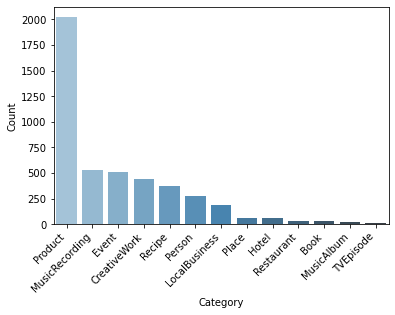

In [15]:
plot = sns.barplot(data=test_smaller, x='Category', y='Count', palette="Blues_d")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [17]:
small = pd.read_csv('../../src/data/schemafiltereddata/TrainTestTables/Small/STrain_Files.csv')
small_statistics = small['Class'].value_counts()
small_statistics = pd.DataFrame(small_statistics)
small_statistics = small_statistics.reset_index()
small_statistics = small_statistics.rename(columns={'index':'Category', 'Class':'Count'})
small_statistics

Category  Count
0          Product   1033
1   MusicRecording    318
2            Event    248
3     CreativeWork    221
4           Recipe    195
5           Person    163
6    LocalBusiness    123
7            Place     38
8            Hotel     38
9             Book     29
10      Restaurant     20
11      MusicAlbum      9
12       TVEpisode      9

[Text(0, 0, 'Product'),
 Text(1, 0, 'MusicRecording'),
 Text(2, 0, 'Event'),
 Text(3, 0, 'CreativeWork'),
 Text(4, 0, 'Recipe'),
 Text(5, 0, 'Person'),
 Text(6, 0, 'LocalBusiness'),
 Text(7, 0, 'Place'),
 Text(8, 0, 'Hotel'),
 Text(9, 0, 'Book'),
 Text(10, 0, 'Restaurant'),
 Text(11, 0, 'MusicAlbum'),
 Text(12, 0, 'TVEpisode')]

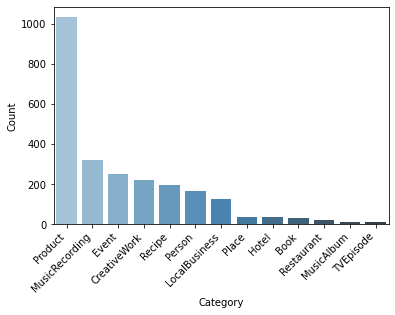

In [18]:
plot = sns.barplot(data=small_statistics, x='Category', y='Count', palette="Blues_d")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [19]:
medium = pd.read_csv('../../src/data/schemafiltereddata/TrainTestTables/Medium/MTrain_Files.csv')
medium_statistics = medium['Class'].value_counts()
medium_statistics = pd.DataFrame(medium_statistics)
medium_statistics = medium_statistics.reset_index()
medium_statistics = medium_statistics.rename(columns={'index':'Category', 'Class':'Count'})
medium_statistics

Category  Count
0          Product   4256
1   MusicRecording   1102
2            Event   1007
3     CreativeWork    869
4           Recipe    770
5           Person    690
6    LocalBusiness    490
7            Place    160
8            Hotel    156
9             Book    118
10      Restaurant     79
11      MusicAlbum     41
12       TVEpisode     38

[Text(0, 0, 'Product'),
 Text(1, 0, 'MusicRecording'),
 Text(2, 0, 'Event'),
 Text(3, 0, 'CreativeWork'),
 Text(4, 0, 'Recipe'),
 Text(5, 0, 'Person'),
 Text(6, 0, 'LocalBusiness'),
 Text(7, 0, 'Place'),
 Text(8, 0, 'Hotel'),
 Text(9, 0, 'Book'),
 Text(10, 0, 'Restaurant'),
 Text(11, 0, 'MusicAlbum'),
 Text(12, 0, 'TVEpisode')]

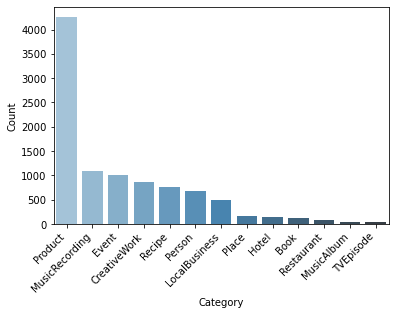

In [20]:
plot = sns.barplot(data=medium_statistics, x='Category', y='Count', palette="Blues_d")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [22]:
large = pd.read_csv('../../src/data/schemafiltereddata/TrainTestTables/Large/Training_Files.csv')
large_statistics = large['Class'].value_counts()
large_statistics = pd.DataFrame(large_statistics)
large_statistics = large_statistics.reset_index()
large_statistics = large_statistics.rename(columns={'index':'Category', 'Class':'Count'})
large_statistics

Category  Count
0          Product  19367
1   MusicRecording   5031
2            Event   4563
3     CreativeWork   3925
4           Recipe   3522
5           Person   3148
6    LocalBusiness   2209
7            Place    728
8            Hotel    701
9             Book    537
10      Restaurant    353
11      MusicAlbum    189
12       TVEpisode    162

[Text(0, 0, 'Product'),
 Text(1, 0, 'MusicRecording'),
 Text(2, 0, 'Event'),
 Text(3, 0, 'CreativeWork'),
 Text(4, 0, 'Recipe'),
 Text(5, 0, 'Person'),
 Text(6, 0, 'LocalBusiness'),
 Text(7, 0, 'Place'),
 Text(8, 0, 'Hotel'),
 Text(9, 0, 'Book'),
 Text(10, 0, 'Restaurant'),
 Text(11, 0, 'MusicAlbum'),
 Text(12, 0, 'TVEpisode')]

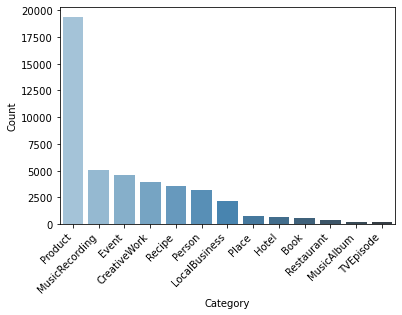

In [23]:
plot = sns.barplot(data=large_statistics, x='Category', y='Count', palette="Blues_d")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')